In [3]:
!pip install datasets torch==1.13.1 transformers==4.30.1 accelerate==0.21.0 bitsandbytes   peft trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 109.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.0/118.0 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━

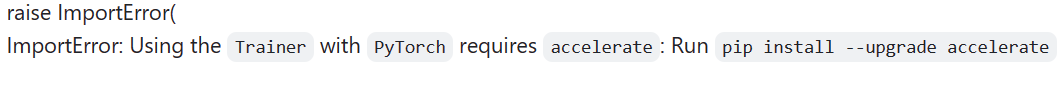

In [2]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


View dataset here :

Format : jsonl

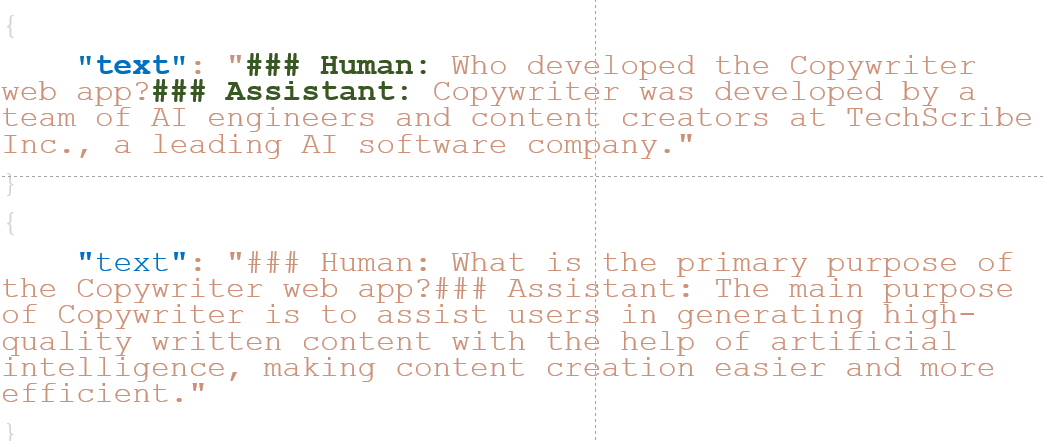

In [4]:
from datasets import load_dataset

# Load your JSON dataset from Gdrive
dataset = load_dataset('json',
                        data_files="/content/drive/MyDrive/training data/copywrite_ft.jsonl",
                        split="train")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 30
})


In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

Need HuggingFace login and access rights to model

Get access to required model from huggingface

https://huggingface.co/meta-llama/Llama-2-7b-chat-hf

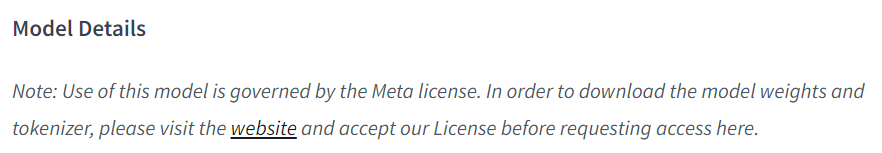

https://ai.meta.com/resources/models-and-libraries/llama-downloads/

https://huggingface.co/settings/tokens

In [7]:
from huggingface_hub import login
login()

 Llama-2-Chat
 Fine tuned for dialogue use case
hf - hugging face

In [8]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

AutoTokenizer is a class from the Transformers library that is used to load and use tokenizers for Transformers models. Tokenizers are used to split text into tokens, which are the basic units of input for Transformers models.

Output Dictionary:
{'input_ids': [25005, 2002, 2881, 2001, 6028], 'token_type_ids': [0, 0, 0, 0, 0]}

Quantization of Transformers models using the BitsAndBytes library

In [9]:
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

# Set the padding token of the tokenizer to the EOS token.
# Common practice when using Transformers models for text generation tasks.
tokenizer.pad_token = tokenizer.eos_token

In [10]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # Quantize to 4-bit precision
    bnb_4bit_quant_type="nf4", #  NF4 quantization type should be used. NF4 is a type of 4-bit quantization that is specifically designed for Transformers models.
    bnb_4bit_compute_dtype=torch.float16, # Model should be computed in float16 precision
)

AutoModelForCausalLM is a class from the Transformers library that is used to load and use causal language models (CLMs). CLMs are a type of language model that can generate text by predicting the next word in a sequence, given the previous words in the sequence.

Used to fine-tune pre-trained CLMs on custom datasets

In [11]:
model = AutoModelForCausalLM.from_pretrained(
    model_name, # Load this model
    quantization_config=bnb_config, # Quantize like this
    trust_remote_code=True # download the model from the Hugging Face Hub if it is not already cached locally
)

# Disable the caching mechanism of the Transformers model.
# BitsAndBytes library does not support caching for quantized models.
model.config.use_cache = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [12]:
from peft import LoraConfig, get_peft_model

''' Strength of the LoRA adaptation.
 Higher values of lora_alpha will result in stronger adaptation,
 but may also lead to overfitting.'''
lora_alpha = 16

lora_dropout = 0.1

# Rank of the LoRA adaptation matrix.
# A higher rank will allow the LoRA adapter to learn more complex adaptations, but will also require more parameters.
lora_r = 64

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM"
)

In [13]:
# Create PeftModel
# Base model - which you can load from the 🤗 Transformers library
# PeftConfig containing the instructions for how to configure a model for LoRa method.
model = get_peft_model(model,peft_config)

In [14]:
model.print_trainable_parameters()

trainable params: 33,554,432 || all params: 6,771,970,048 || trainable%: 0.49548996469513035


In [15]:
from transformers import TrainingArguments

output_dir = "/content/drive/MyDrive/training data/results"

# Number of training examples per device in each batch
per_device_train_batch_size = 4

# Number of batches to accumulate gradients before performing an update to the model weights
gradient_accumulation_steps = 4

# Specialized optimizer for training LLMs on GPUs
optim = "paged_adamw_32bit"

# How often to save the model checkpoint during training
save_steps = 100

# How often to log the training metrics during training
logging_steps = 10

learning_rate = 2e-4
max_grad_norm = 0.3

# Epoch
max_steps = 100

# How quickly the learning rate is increased during the initial stages of training
warmup_ratio = 0.03

# Keeps the learning rate constant throughout training
lr_scheduler_type = "constant"

training_arguments = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    fp16=True,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=True,
    lr_scheduler_type=lr_scheduler_type,
)

In [16]:
from trl import SFTTrainer

max_seq_length = 512

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    dataset_text_field="text",
    tokenizer=tokenizer,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    args=training_arguments,
)

Map:   0%|          | 0/30 [00:00<?, ? examples/s]

Convert all of the normalization layers in a Transformers model to float32 precision. This can be helpful for improving the performance of the model on GPUs

In [17]:
for name, module in trainer.model.named_modules():
    if "norm" in name:
        module = module.to(torch.float32)

In [18]:
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
10,2.361200
20,1.298600
30,0.698200
40,0.309700
50,0.123700
60,0.098900
70,0.091500
80,0.079700
90,0.072900
100,0.071300


TrainOutput(global_step=100, training_loss=0.5205805844068527, metrics={'train_runtime': 273.3182, 'train_samples_per_second': 5.854, 'train_steps_per_second': 0.366, 'total_flos': 1645885204561920.0, 'train_loss': 0.5205805844068527, 'epoch': 50.0})

The trainer.model.module attribute returns the underlying model that is being trained by the Trainer class. If the Trainer class is being used for distributed or parallel training, then the trainer.model.module attribute will be a distributed or parallel model. In this case, it is important to save the trainer.model.module attribute instead of the trainer.model attribute.

The hattr function is used to check if the trainer.model attribute has a module attribute. If it does, then the trainer.model.module attribute is saved. Otherwise, the trainer.model attribute is saved.

In [19]:
model_to_save = trainer.model.module if hasattr(trainer.model, 'module') else trainer.model  # Take care of distributed/parallel training
model_to_save.save_pretrained("/content/drive/MyDrive/training data/outputs")

The LoraConfig.from_pretrained() method is used to load a pre-trained LoRA adapter from the specified directory. The get_peft_model() method is used to apply the LoRA adapter to a Transformers model.

In [20]:
lora_config = LoraConfig.from_pretrained('/content/drive/MyDrive/training data/outputs')
model = get_peft_model(model, lora_config)

In [22]:
text = "###Human: Give me some good reasons to buy the copyrighter web app. ### Assistant: "
device = "cuda:0"

# Tokenize a text input and convert it to a PyTorch tensor on the specified device.
inputs = tokenizer(text, return_tensors="pt").to(device)


In [23]:
model.print_trainable_parameters()

trainable params: 0 || all params: 6,771,970,048 || trainable%: 0.0


# Generate text using a PyTorch language model.


The model.generate() function is used to generate text from the given input IDs. The max_new_tokens argument specifies the maximum number of tokens to generate.

The tokenizer.decode() function is used to decode the generated token IDs into text. The skip_special_tokens=True argument specifies that the tokenizer should skip the special tokens (such as the start-of-sequence and end-of-sequence tokens) when decoding the text.

In [24]:
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

###Human: Give me some good reasons to buy the copyrighter web app. ### Assistant:  Certainly! Here are some good reasons to consider purchasing the Copyright web app:

1. Time-saving: The Copyright web app is designed to streamline the copyright registration process, saving you time and effort. With just a few clicks, you can register your work and receive a legally binding copyright certificate.

2. Accurate registration: The app uses advanced algorithms to ensure that your work is registered accurately and efficiently. This reduces the


In [26]:
outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=100)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

###Human: Who created the copyrighter web app. ### Assistant:  The Copyright Web App was created by a team of developers and designers who are passionate about making copyright and licensing easy and accessible for creators and content owners. The app was launched in 2019 and has since helped thousands of creators manage their copyrights and licenses in a simple and efficient way.



